<a href="https://colab.research.google.com/github/SivenM/unet_test/blob/master/Mobile_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ноутбук для Mobile_Unet. 

Генераторы, модель, обучение и тестирование проводится здесь. 

Датасет взят из:
https://supervise.ly/explore/projects/supervisely-person-dataset-23304/datasets

и хранится в gdrive (unet_dataset).

3500 --> train

500 --> val

400 --> test

##Получим доступ к gdrive и загруим датасет в среду.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
#пути для тренироваочных изображений и масок
img_train_dir = '/content/gdrive/My Drive/unet_dataset/train/images' 
mask_train_dir = '/content/gdrive/My Drive/unet_dataset/train/masks'

#пути для проверочных изображений и масок
img_val_dir = '/content/gdrive/My Drive/unet_dataset/validation/images' 
mask_val_dir = '/content/gdrive/My Drive/unet_dataset/validation/masks'

#пути для тестовых данных
img_test_dir = '/content/gdrive/My Drive/unet_dataset/test/images' 
mask_test_dir = '/content/gdrive/My Drive/unet_dataset/test/masks'

In [0]:
 %tensorflow_version 2.x

# MobileNet

MobileNet выступает в качестве энкодера для Unet.

Загрузим MobileNet с предобученными весами:

In [5]:
from tensorflow.keras.applications import MobileNet

mn = MobileNet(weights='imagenet',
                 include_top=False,
                 input_shape=(512, 512, 3))
mn.trainable=False

##Архитектура нейронной сети:

![alt text](https://raw.githubusercontent.com/zhixuhao/unet/master/img/u-net-architecture.png)

##Модель unet

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import optimizers

def m_unet(encoder):
  x = encoder
  up1 = layers.Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(x.get_layer('conv_pw_13_relu').output))
  merge1 = layers.concatenate([x.get_layer('conv_pw_11_relu').output,up1], axis = 3)
  conv1 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge1)
  conv1 = layers.Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  
  up2 = layers.Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv1))
  merge2 = layers.concatenate([x.get_layer('conv_pw_5_relu').output,up2], axis = 3)
  conv2 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge2)
  conv2 = layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  
  up3 = layers.Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv2))
  merge3 = layers.concatenate([x.get_layer('conv_pw_3_relu').output,up3], axis = 3)
  conv3 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
  conv3 = layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  
  up4 = layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv3))
  merge4 = layers.concatenate([x.get_layer('conv_pw_1_relu').output,up4], axis = 3)
  conv4 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge4)
  conv4 = layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  
  conv5 = layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(layers.UpSampling2D(size = (2,2))(conv4))
  conv5 = layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  conv5 = layers.Conv2D(1, 1, activation = 'sigmoid')(conv5)
  
  mobile_net = Model(x.input, conv5)
  miou = tf.keras.metrics.MeanIoU(num_classes=2)
  mobile_net.compile(loss= 'binary_crossentropy', 
                optimizer= optimizers.Adam(lr=1.3e-4),                 
                metrics=['acc', miou])
  return mobile_net

In [0]:
model = m_unet(mn)

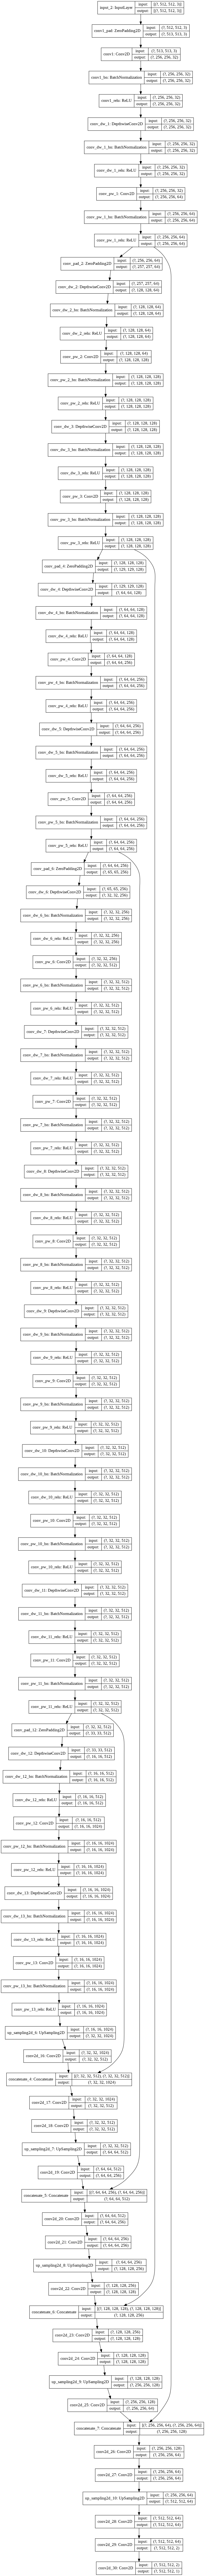

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

#Генераторы для данных:

train_generator - генератор для тренировочных данных

val_generator - генератор для проверочных данных

test_generator - генератор для контрольных данных

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def train_generator(img_train_dir, mask_train_dir):
  train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True) 
  img_train_generator = train_datagen.flow_from_directory(
        img_train_dir,
        target_size=(512,512),
        batch_size=5,
        seed=1,
        class_mode=None,)
  mask_train_generator = train_datagen.flow_from_directory(
        mask_train_dir,
        target_size=(512,512),
        batch_size=5,
        color_mode="grayscale",
        seed=1,
        class_mode=None,)
  train_gen = zip(img_train_generator, mask_train_generator)
  for (img, mask) in train_gen:
    mask[mask > 0.9] = 1
    mask[mask <= 0.9] = 0
    yield (img,mask)

def val_generator(img_val_dir, mask_val_dir):
  val_datagen = ImageDataGenerator(rescale=1./255)
  img_val_generator = val_datagen.flow_from_directory(
        img_val_dir,
        target_size=(512,512),
        batch_size=5,
        seed=1,
        class_mode=None,)
  mask_val_generator = val_datagen.flow_from_directory(
        mask_val_dir,
        target_size=(512,512),
        batch_size=5,
        color_mode="grayscale",
        seed=1,
        class_mode=None,)      
  val_gen = zip(img_val_generator, mask_val_generator)
  for (img, mask) in val_gen:
    mask[mask == 1] = 1
    mask[mask <= 1] = 0
    yield (img,mask)

def test_generator(img_test_dir, mask_test_dir):
  test_datagen = ImageDataGenerator(rescale=1./255)
  test_img_generator = test_datagen.flow_from_directory(
      img_test_dir,
      target_size =(512,512),
      batch_size = 2,
      class_mode=None
  )
  test_mask_generator = test_datagen.flow_from_directory(
      mask_test_dir,
      target_size =(512, 512),
      batch_size=2,
      color_mode="grayscale",
      class_mode=None 
  )
  test_gen = zip(test_img_generator, test_mask_generator)
  for (img, mask) in test_gen:
      mask[mask == 1] = 1
      mask[mask <= 1] = 0
      yield (img,mask)

# Обучение

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard


train_gen = train_generator(img_train_dir, mask_train_dir)
val_gen = val_generator(img_val_dir, mask_val_dir)

callbacks_list = [
                  TensorBoard(
                      log_dir='/content/l_dir',
                      histogram_freq=1,
                  ),
                  EarlyStopping(
                      monitor='val_acc',
                      patience=3,
                  ),
                  ModelCheckpoint(
                      filepath='/content/gdrive/My Drive/Mobile_UNet/MU_v4.h5',
                      monitor='val_acc',
                      save_best_only=True,
                  )
]

history = model.fit_generator(
    train_gen,
    steps_per_epoch=700,
    epochs=30,
    callbacks=callbacks_list,
    validation_data=val_gen,
    validation_steps=100
)


Found 3500 images belonging to 1 classes.
Found 3500 images belonging to 1 classes.
Epoch 1/30
700/700 [==============================] - ETA: 0s - loss: 0.2875 - acc: 0.8761 - mean_io_u: 0.3783Found 500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.
700/700 [==============================] - 7535s 11s/step - loss: 0.2875 - acc: 0.8761 - mean_io_u: 0.3783 - val_loss: 0.6249 - val_acc: 0.7584 - val_mean_io_u: 1.0000
Epoch 2/30
700/700 [==============================] - 552s 789ms/step - loss: 0.2290 - acc: 0.9096 - mean_io_u: 0.3780 - val_loss: 0.5609 - val_acc: 0.7627 - val_mean_io_u: 1.0000
Epoch 3/30
700/700 [==============================] - 554s 791ms/step - loss: 0.1984 - acc: 0.9232 - mean_io_u: 0.3792 - val_loss: 0.5135 - val_acc: 0.7775 - val_mean_io_u: 1.0000
Epoch 4/30
700/700 [==============================] - 557s 796ms/step - loss: 0.1886 - acc: 0.9266 - mean_io_u: 0.3787 - val_loss: 0.5132 - val_acc: 0.7729 - val_mean_io_u: 1.0000
Epoch 5/30
700/7

In [0]:
model.save('/content/gdrive/My Drive/Mobile_UNetmobiletunet_v1.h5')

# Проверка на контрольных данных

In [17]:
test_generator = test_generator(img_test_dir, mask_test_dir) 
test_loss, test_acc, test_iou = model.evaluate_generator(test_generator, steps=200)
print('test mIOU: ', test_iou)
print('test acc:', test_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
Found 400 images belonging to 1 classes.
Found 400 images belonging to 1 classes.
test mIOU:  1.0
test acc: 0.790610671043396


# Результат на единичном экземпляре

In [0]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt


def predToGrayImage(segment):
  img = np.zeros((segment.shape[0], segment.shape[1], 3))
  img[:, :, 0] = segment[:, :, 0]*254
  img[:, :, 1] = img[:, :, 0] #Make greyscale
  img[:, :, 2] = img[:, :, 0] #Make greyscale
  return img.astype('uint8')

def img_preproc(img_path):
  """Возвращает нормированный 4ех-мерный тензор"""
  img = image.load_img(img_path, target_size=(512,512))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  img_tensor /= 255.
  return img_tensor

def img_pred(img_path):
  img_tensor = img_preproc(img_path)
  #img_tensor_grayscale = tf.image.rgb_to_grayscale(img_tensor, name=None)
  result = model.predict(img_tensor)
  mask = predToGrayImage(result[0])
  plt.imshow(img_tensor[0])
  plt.imshow(mask)
  plt.show()

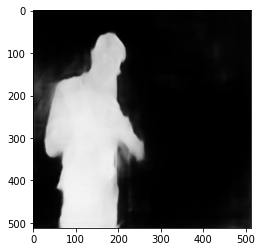

In [26]:
img_path = '/content/gdrive/My Drive/sbfLoK09oy0.jpg'

img_tensor = img_preproc(img_path)

result = model.predict(img_tensor)

mask = predToGrayImage(result[0])
plt.imshow(mask)
plt.show()

In [0]:
#!pip install -q tf-nightly
%load_ext tensorboard

In [40]:
!pip uninstall -q tf-nightly

Proceed (y/n)? y


In [0]:
from tensorflow import estimator

In [47]:
%tensorboard --logdir /content/logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/main.py", line 43, in <module>
    from tensorboard import default
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/default.py", line 40, in <module>
    from tensorboard.plugins.beholder import beholder_plugin_loader
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/plugins/beholder/__init__.py", line 22, in <module>
    from tensorboard.plugins.beholder.beholder import Beholder
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/plugins/beholder/beholder.py", line 212, in <module>
    class BeholderHook(tf.estimator.SessionRunHook):
AttributeError: module 'tensorflow' has no attribute 'estimator'